In [1]:
import jax
import anon
import anabel
import anabel.backend as anp
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("typewriter")
from poisson import H1_v1 as H1
from poisson import L2
from poisson import poisson2 as poisson
from interpolate import lagrange_t6
jax.config.update("jax_enable_x64", True)
PI = anp.pi
H = [ 
  0.50000,
  0.25000,
  0.12500,
  0.06250,
  0.03125,
]

In [2]:
pblmset = [ 
    dict(
        u = lambda x: 1 - x[0]**2 - x[1]**2,
        tag = ""
    ),
    dict(
        tag="-b",
        u = lambda x: anp.cos(PI/2*anp.linalg.norm(x))
    )
]

In [3]:
table_file = "../convergence-tab.md"
file = open(table_file,"r+")
file. truncate(0)
file. close()

	
		mesh 1, order 2
mesh1-gauss02.npz
		[0.00247645780711961]
		mesh 1, order 5
mesh1-gauss05.npz
		[0.0030141853980206767]
		mesh 1, order 13
mesh1-gauss13.npz
		[0.0029849952789655016]
		mesh 1, order 19
mesh1-gauss19.npz
		[0.0029849952789651186]
		mesh 2, order 2
mesh2-gauss02.npz
		[0.00247645780711961, 0.0002258162025240618]
		mesh 2, order 5
mesh2-gauss05.npz
		[0.0030141853980206767, 0.00027375659236046553]
		mesh 2, order 13
mesh2-gauss13.npz
		[0.0029849952789655016, 0.00027090969056475843]
		mesh 2, order 19
mesh2-gauss19.npz
		[0.0029849952789651186, 0.00027090969056391237]
		mesh 3, order 2
mesh3-gauss02.npz
		[0.00247645780711961, 0.0002258162025240618, 2.1527456729706605e-05]
		mesh 3, order 5
mesh3-gauss05.npz
		[0.0030141853980206767, 0.00027375659236046553, 2.5708535948061896e-05]
		mesh 3, order 13
mesh3-gauss13.npz
		[0.0029849952789655016, 0.00027090969056475843, 2.5448945104106088e-05]
		mesh 3, order 19
mesh3-gauss19.npz
		[0.0029849952789651186, 0.00027090969056

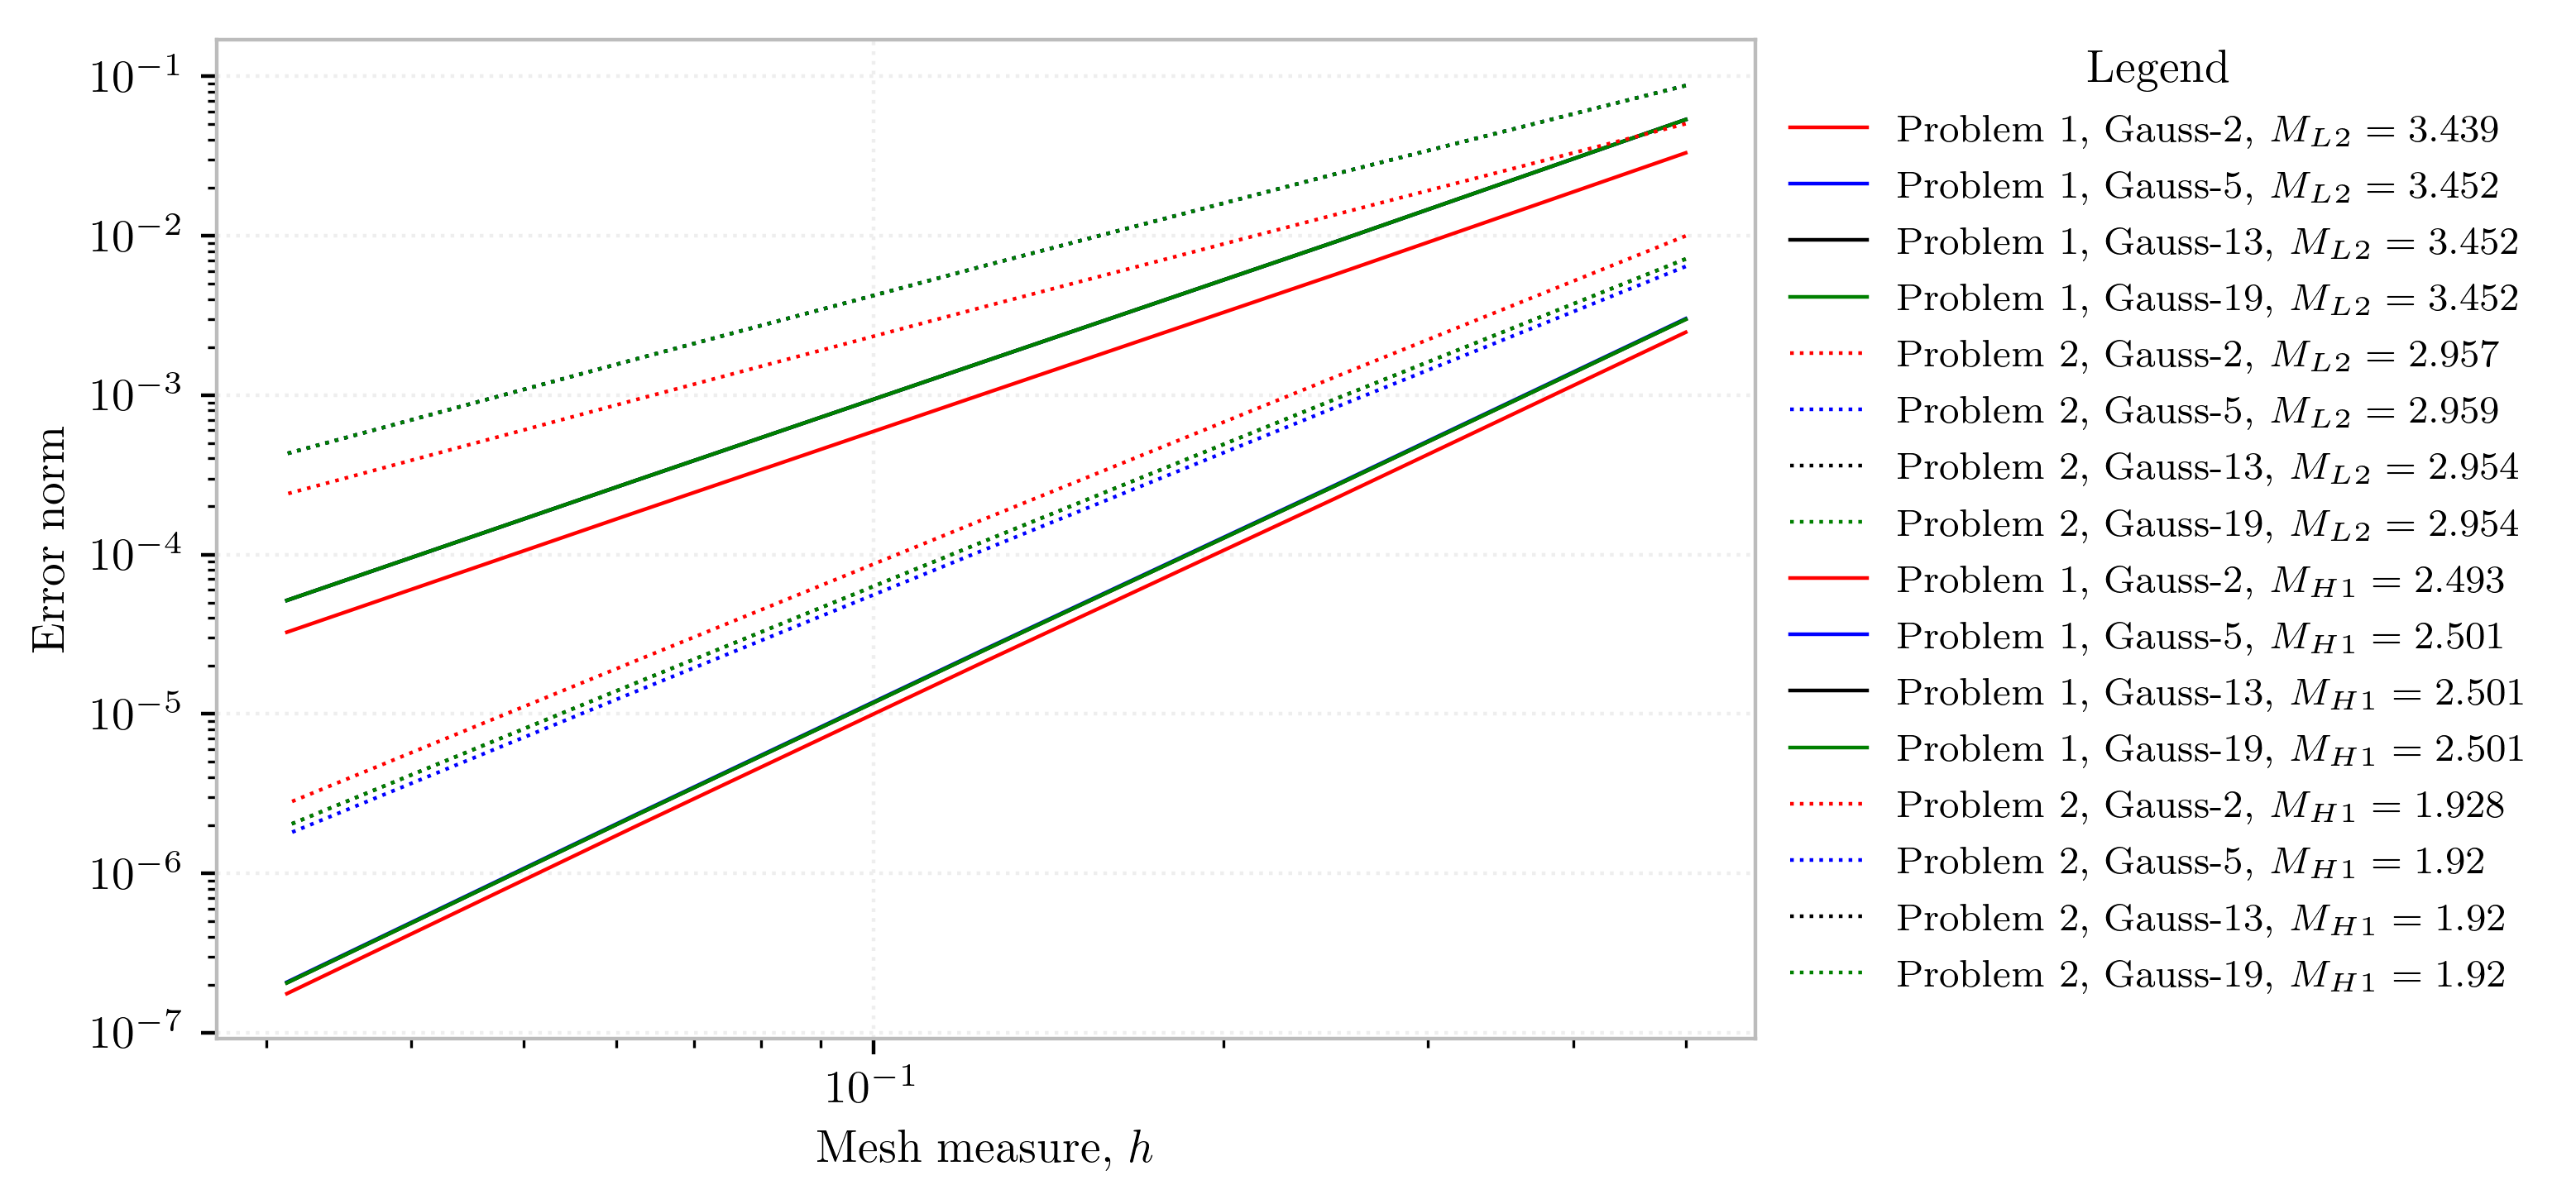

In [4]:
fig, ax = plt.subplots()
meshes = [1,2,3,4,5]#,4,5]
orders = [2,5,13,19]
for n,norm in enumerate(["L2","H1"]):
    for p,problem in enumerate(pblmset[:]):
        u,tag = problem["u"], problem["tag"]
        marker = "-:"[p]
        ofst = "\t"
        print(ofst+tag)
        ofst += "\t"
        e, h = [[] for g in orders], [[] for g in orders]
        for m in meshes:
            model =  anabel.MeshGroup.read(f"../dat/circle_iso/mesh{m}", "m228", cell="triangle6")
            if norm == "H1":
                _E = model.assemble_integral(elem=H1(*[lagrange_t6()]*3,u=u))
                E = lambda uh,**kwds: np.sqrt(sum(np.asarray(_E(uh,**kwds)))) 
            else:
                _E = model.assemble_integral(elem=L2(*[lagrange_t6()]*3,u=u))
                E = lambda uh,**kwds: np.sqrt(sum(np.asarray(_E(uh,**kwds)))) 

            for g,o in enumerate(orders):
                print(ofst+f"mesh {m}, order {o}")
                try:
                    print(f"mesh{m}-gauss{o:02}{tag}.npz")
                    Uh = anp.load(f"../out/mesh{m}-gauss{o:02}{tag}.npz")["arr_0"] + 0.0
                except:
                    print(ofst+"\tLoad failed.")
                    continue
                h[g].append(H[m-1])
                quad = anon.quad.simplex.Simplex.load(f"../dat/quadrature/gauss{o:02}.m")
                e[g].append(float(E(Uh,points=quad.points,weights=quad.weights)))
                print(ofst+f"{e[g]}")
            del model
        for g,m in zip(range(len(orders)),range(len(meshes))):
            slope, ss = np.polyfit(np.log(h[g]), np.log(e[g]), 1)
            ax.loglog(h[g],e[g],
                      marker,
                      color="bkgrbkgrbkgrbkgr"[m-1],
                      label=f"Problem {'12'[p]}, Gauss-{orders[g]}, $M_{{{norm}}}={slope:.04}$")
            
        with open(table_file,"a") as f:
            print(f"\nTable of errors in the {norm} norm for problem {str(p+1)}",file=f)
            print("| $h$ | "+" | ".join(map(str,orders)) + " |", file=f)
            print("|-----|-"+ "|".join( ["----"]*len(orders)) + "|", file=f)
            for m in meshes:
                print(f"| {H[m-1]} |" + " | ".join(f"{e[g][m-1]:.08}" for g in range(len(orders))) + " |",
                      file=f)
ax.set_xlabel("Mesh measure, $h$")
ax.set_ylabel("Error norm")
fig.legend(title='Legend', bbox_to_anchor=(0.9, 0.9), loc='upper left', fontsize='small')
fig.savefig("../img/conv-3.png")

In [5]:
print(h)

[[0.5, 0.25, 0.125, 0.0625, 0.03125], [0.5, 0.25, 0.125, 0.0625, 0.03125], [0.5, 0.25, 0.125, 0.0625, 0.03125], [0.5, 0.25, 0.125, 0.0625, 0.03125]]


In [6]:
# model.plot(func=u)